In [1]:
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
import numpy as np

# Supported files:
# 1. a9a.txt
# 2. w8a.txt
# 3. ijcnn1
# 4. covtype.libsvm.binary

def data_loader(file_name='a9a.txt'):
    # Load in data and get rid of last column
    X, y = load_svmlight_file(file_name)
    
    # Convert to numpy array
    X = X.todense()
    return X, y



In [3]:
X, y = data_loader('a9a.txt')

print(X.shape)

(32561, 123)


In [4]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
y_train.shape

(24420,)

In [7]:
from sklearn.covariance import GraphicalLasso

cov = GraphicalLasso(max_iter=1000).fit(X_train)

A = cov.covariance_

/usr/local/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -8.964e-02
  warnings.warn('graphical_lasso: did not converge after '


In [8]:
def lossfn(U, w, x, A, lambda_=1e-5):
    # U -> input, w -> label
    f = np.mean( 1 / ( 1 + np.exp(np.dot(U, x) * w)) ) 
    g = lambda_ * np.linalg.norm(np.dot(A, x), ord=1)
    return f + g

In [9]:
def gradf(U, w, x):
    # U (n,d) ; w (n,1) ; x (d,1)
    expfn = 1 / ( 1 + np.exp(np.dot(U, x) * w)) # (n,1)
    return np.mean( expfn * ( expfn - 1 ) * (U * w), axis = 0).reshape(x.shape)

In [10]:
def soft_threshold(x, t=1):
    return np.sign(x) * np.maximum( np.abs(x) - t, 0)

def update_y(x, y, z, rho, A, lambda_):
    return 1 / (rho + 1) * soft_threshold(rho * np.dot(A, x) + y - z, lambda_)

In [11]:
def update_x(x, y, z, v, rho, eta, A):
    return x - eta * ( v + rho * np.dot(A, (np.dot(A, x) - y - z / rho) ))

In [31]:
def update_s(rho, A, B, z_1, z_0):
    return rho * A.T @ B @ (z_1 - z_0)

def update_r(A, B, x, z, c):
    return A @ x + B @ z - c

def update_rho(rho, r, s, mu=1.25, tau_incr=1.25, tau_decr=1.25):
    r_n = np.linalg.norm(r, ord=2)
    s_n = np.linalg.norm(s, ord=2)
    if r_n > mu*s_n:
        return tau_incr * rho
    if s_n > mu*r_n:
        return rho / tau_decr
    return rho

In [25]:
def spider_admm(b, q, K, eta, rho, U, w, A, lambda_):
    n, d = U.shape
    x = np.zeros((d,1))
    y = np.zeros((d,1))
    z = np.zeros((d,1))
    w = w.reshape((len(w), 1))
    B = -np.eye(d)
    c = np.zeros((d,1))
    #dual residual
    s = np.zeros((d,1))
    #primal residual
    r = np.zeros((d,1))

    
    xprev = x.copy()
    ind = np.random.permutation(np.arange(n))
    i = 0
    loss = []

    for k in range(K):
        if (k % q) == 0:
            vk = gradf(U, w, x)
        else:
            indb = ind[i:i+b]
            i += b
            if i >= n:
                i = 0
            Ub, wb = U[indb, :], w[indb]
            vk = gradf(Ub, wb, x) - gradf(Ub, wb, xprev) + vk            
        
        # print(vk)
        rho = update_rho(rho, r, s)
        
        y = update_y(x, y, z, rho, A, lambda_)
        xprev = x.copy()
        x = update_x(x, y, z, vk, rho, eta, A)
        z_0 = z.copy()
        z = z - rho * (A @ x + B @ y - c)
        s = update_s(rho, A, B, z_1=z, z_0=z_0)
        r = update_r(A, B, x, z, c)

        l = lossfn(U, w, x, A, lambda_)
        # print("k:", k, "Loss:", l)
        print("k:", k,"rho:",rho,"r:",np.linalg.norm(r, ord=2),"s:",np.linalg.norm(s, ord=2),"Loss:", l)
        loss.append(l)
    
    return x, y, z, loss

In [32]:
b = 32
q = 10
eta = 0.05
rho = 0.5
lambda_ = 1e-5
K = 5000
x, y, z, loss = spider_admm(b, q, K, eta, rho, X_train, y_train, A, lambda_)

k: 0 rho: 0.5 r: 0.09110769104123244 s: 0.07085431225553186 Loss: 0.49629552786052167
k: 1 rho: 0.625 r: 0.12755235104506518 s: 0.05983498390455367 Loss: 0.4951455891145371
k: 2 rho: 0.78125 r: 0.14605777713716023 s: 0.014011934433931141 Loss: 0.49409076511684147
k: 3 rho: 0.9765625 r: 0.17962481557567522 s: 0.018301538222914245 Loss: 0.492198745019719
k: 4 rho: 1.220703125 r: 0.2164163665954271 s: 0.03988227876108134 Loss: 0.49024860213284305
k: 5 rho: 1.52587890625 r: 0.2539498324442219 s: 0.05831695256251424 Loss: 0.48834042031776276
k: 6 rho: 1.9073486328125 r: 0.2952533290071991 s: 0.10119782334865662 Loss: 0.48641639580068385
k: 7 rho: 2.384185791015625 r: 0.33759023826418655 s: 0.14297185125043677 Loss: 0.48453334071469406
k: 8 rho: 2.9802322387695312 r: 0.38588424838703594 s: 0.25385501120668535 Loss: 0.4826212042629846
k: 9 rho: 3.725290298461914 r: 0.43384273797460726 s: 0.32342821562124396 Loss: 0.4807675403104727
k: 10 rho: 4.656612873077393 r: 0.49562703344036496 s: 0.6831

Text(0.5, 1.0, 'SPIDER-ADMM')

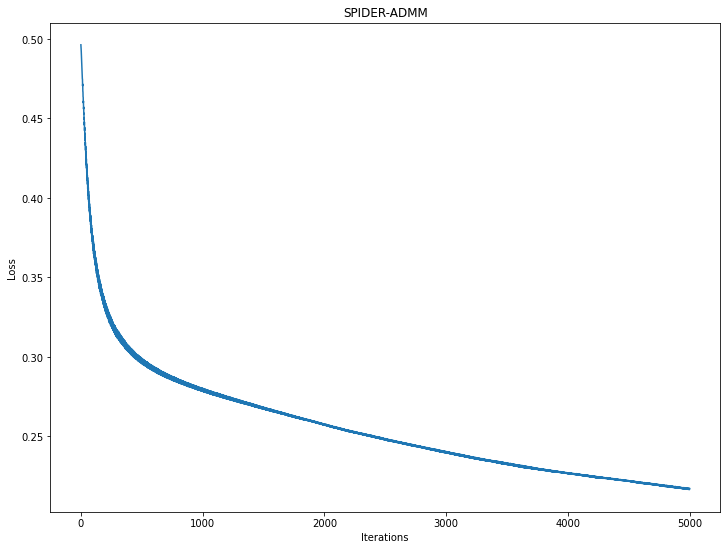

In [33]:
plt.figure(figsize=(12,9))
plt.plot(loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("SPIDER-ADMM")

In [ ]:
# if we want to use pytorch to calculate the sgd of f(x)
# class f(torch.nn.Module):

In [2]:
def lagrangian(x_k, y_k1, y_j, y_k, z_k): pass

def lagrangian_hat(x, y_k1, z_k, v_k): pass

In [ ]:
def reg_vk(k, q, ...):
    # use some sgd library?
    if k % q == 0:
        vk = ...
    else:
        vk = ...

    return vk

# implement later
# def online_vk(k, q, ...):
#     if k % q == 0:
#         vk = ...
#     else:
#         vk = ...

#     return vk

In [ ]:
# Let b1 = None unless performing online algo (rename if necessary)
def spider_admm(b1, b2, q, K, n, p):
    # init
    x_k = ...
    j = ...
    y_k = ...
    z_k = ...
    
    for k in range(K):
        if b1 is None: 
            vk = reg_vk(k, q, ...)
        else: 
            # implement later
            # vk = online_vk(k, q, ...)
        
        # update k + 1 for y, x, z
        # probably do not need separate k + 1 variables

        # using lagrangian
        lagrs = []
        for j in range(m):
            y_k[j] = np.argmin(...)

        # using lagrangian hat
        lagr_hats = []
        x_k = np.argmin(...)

        z_k = ...

    return [x_k, y_k, z_k]

def online_spider_admm(b1, b2, q, K, n, p): 
    return spider_admm(b1, b2, q, K, n, p)